# MS009 Preprocess
01/25/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS009'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/raw/MS009_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2207039  =      0.000 ...  2155.312 secs...


In [7]:
mne_data

<RawEDF | MS009_SWB.edf, 276 x 2207040 (2155.3 s), ~4.54 GB, data loaded>

In [8]:
# mne_data.ch_names

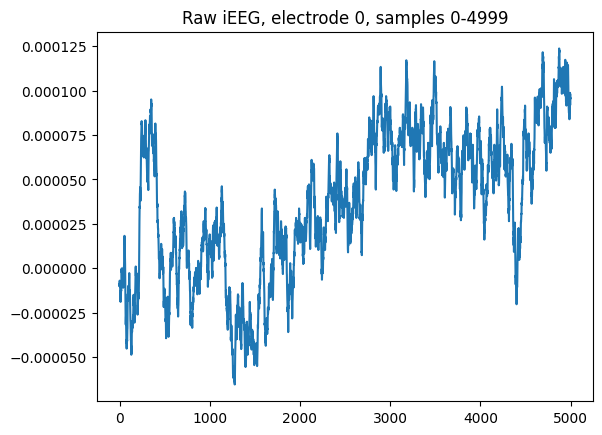

In [8]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [9]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    7.8s
[Paralle

<RawEDF | MS009_SWB.edf, 276 x 1077656 (2155.3 s), ~2.22 GB, data loaded>

### Photodiode
- examine photodiode 

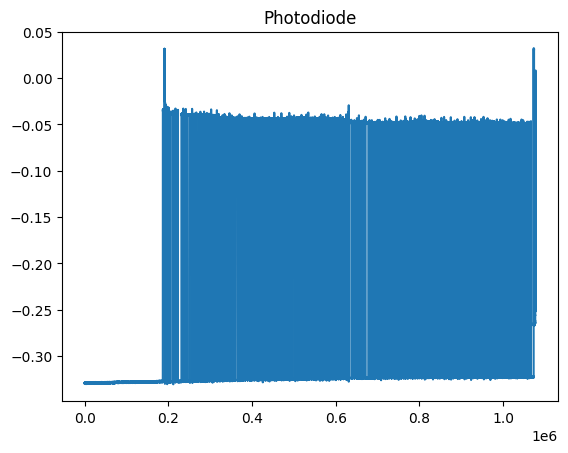

In [11]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [12]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/photodiode.fif
[done]


In [13]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS009_SWB.edf, 275 x 1077656 (2155.3 s), ~2.21 GB, data loaded>

### Notch filter line noise

In [14]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:   11.4s finished


<RawEDF | MS009_SWB.edf, 275 x 1077656 (2155.3 s), ~2.21 GB, data loaded>

### Anatomical Localization

In [15]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS009_SWB.edf, 275 x 1077656 (2155.3 s), ~2.21 GB, data loaded>

In [16]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x  \
0     LaCaS1    A32sg_L  -2.198512  42.942225   0.399996  -2.171989   
1    LaCaS10      A9l_L -12.191809  54.538567  42.799993 -12.589239   
2    LaCaS11      A9l_L -13.391005  56.138062  47.999993 -13.741458   
3    LaCaS12    Unknown -15.389664  57.337684  51.599993 -15.762398   
4     LaCaS2    A32sg_L  -3.397708  44.141846   5.199996  -3.528236   
..       ...        ...        ...        ...        ...        ...   
97    LpTpT7    A20cl_L -59.759902 -25.836078  -8.400004 -58.231368   
98    LpTpT8     A21c_L -64.556684 -26.635826  -7.600004 -63.062459   
99    LpTpT9    A37dl_L -69.753199 -27.435573  -6.800004 -68.357228   
100   uLcPpP     A23d_L  -6.995295 -25.836078  21.599995  -5.040701   
101   uLmOlF     A11m_L  -6.595563  58.137431 -10.400003  -6.883270   

         mni_y      mni_z       gm                                  NMM  \
0    31.060445  -9.573366     Gray   Left ACgG anterior cingulate gyrus   
1    50.871375  37.637815     Gray      Left SFG superior frontal gyrus   
2    53.387483  43.456687     Gray      Left SFG superior frontal gyrus   
3    55.196659  47.463093  Unknown                              Unknown   
4    33.282432  -4.187506     Gray   Left ACgG anterior cingulate gyrus   
..         ...        ...      ...                                  ...   
97  -43.255961  -9.333006    White       Left MTG middle temporal gyrus   
98  -44.205698  -8.202658     Gray       Left MTG middle temporal gyrus   
99  -45.185994  -7.211913     Gray       Left MTG middle temporal gyrus   
100 -35.483679  26.399148     Gray  Left PCgG posterior cingulate gyrus   
101  44.408269 -25.791952     Gray                Left GRe gyrus rectus   

         Anat                 AnatMacro    BN246  \
0    Area s24                     L ACC     L CG   
1     Unknown  L Superior Frontal Gyrus    L SFG   
2     Unknown  L Superior Frontal Gyrus    L SFG   
3     Unknown                   Unknown  Unknown   
4    Area s24                     L ACC     L CG   
..        ...                       ...      ...   
97    Unknown   L Middle Temporal Gyrus    L ITG   
98    Unknown   L Middle Temporal Gyrus    L MTG   
99    Unknown   L Middle Temporal Gyrus    L MTG   
100   Unknown                     L PCC     L CG   
101  Area Fo1            L Rectal Gyrus    L OrG   

                                     YBA_1 Manual Examination Notes  
0                   Left cingulate gyrus C                NaN   NaN  
1          Left superior frontal gyrus 2 C                 WM   NaN  
2          Left superior frontal gyrus 2 C                OOB   NaN  
3                                  Unknown                OOB   NaN  
4                   Left cingulate gyrus D                NaN   NaN  
..                                     ...                ...   ...  
97   Left inferior middle temporal gyrus E                 WM   NaN  
98   Left inferior middle temporal gyrus E                 WM   NaN  
99   Left inferior middle temporal gyrus E                NaN   NaN  
100                 Left cingulate gyrus O                NaN   NaN  
101               Left frontal orbital 3 A                NaN   NaN  

[102 rows x 16 columns]

In [17]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAgIT1',
 'LAgIT10',
 'LAgIT11',
 'LAgIT12',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LaIaS1',
 'LaIaS10',
 'LaIaS11',
 'LaIaS12',
 'LaIaS2',
 'LaIaS3',
 'LaIaS4',
 'LaIaS5',
 'LaIaS6',
 'LaIaS7',
 'LaIaS8',
 'LaIaS9',
 'LHpIT1',
 'LHpIT10',
 'LHpIT11',
 'LHpIT12',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LpCpP1',
 'LpCpP2',
 'LpCpP3',
 'LpCpP4',
 'LpCpP5',
 'LpCpP6',
 'LpCpP7',
 'LpCpP8',
 'LpCpP9',
 'LpIpM1',
 'LpIpM10',
 'LpIpM11',
 'LpIpM12',
 'LpIpM13',
 'LpIpM14',
 'LpIpM2',
 'LpIpM3',
 'LpIpM4',
 'LpIpM5',
 'LpIpM6',
 'LpIpM7',
 'LpIpM8',
 'L

In [18]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lmoif1', 'lmoif2', 'lmoif3', 'lmoif4', 'lmoif5', 'lmoif6', 'lmoif7', 'lmoif8', 'lmoif9', 'c10', 'c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'c110', 'c111', 'c112', 'c113', 'c114', 'c115', 'c116', 'c117', 'c118', 'c119', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c150', 'c151', 'c152', 'c153', 'c154', 'c155', 'c156', 'c157', 'c158', 'c159', 'c160', 'c161', 'c162', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c

In [19]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [20]:
unmatched_seeg #make sure there are no unmatched names


[]

In [21]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [23]:
new_name_dict #make sure this passes the eye test 


{'lmoif1': 'lmolf1',
 'lmoif2': 'lmolf2',
 'lmoif3': 'lmolf3',
 'lmoif4': 'lmolf4',
 'lmoif5': 'lmolf5',
 'lmoif6': 'lmolf6',
 'lmoif7': 'lmolf7',
 'lmoif8': 'lmolf8',
 'lmoif9': 'lmolf9',
 'c10': 'c10',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'lmcms1': 'lmcms1',
 'lmcms2': 'lmcms2',
 'lmcms3': 'lmcms3',
 'lmcms4': 'lmcms4',
 'lmcms5': 'lmcms5',
 'lmcms6': 'lmcms6',
 'lmcms7': 'lmcms7',
 'lmcms8': 'lmcms8',
 'lmcms9': 'lmcms9',
 'lmcms10': 'lmcms10',
 'lagit1': 'lagit1',
 'lagit2': 'lagit2',
 'lagit3': 'lagit3',
 'lagit4': 'lagit4',
 'lagit5': 'lagit5',
 'lagit6': 'lagit6',
 'lagit7': 'lagit7',
 'lagit8': 'lagit8',
 'lagit9': 'lagit9',
 'lagit10': 'lagit10',
 'lagit11': 'lagit11',
 'lagit12': 'lagit12',
 'lhpit1': 'lhpit1',
 'lhpit2': 'lhpit2',
 'lhpit3': 'lhpit3',
 'lhp

In [24]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS009_SWB.edf, 275 x 1077656 (2155.3 s), ~2.21 GB, data loaded>

In [25]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 100 left sEEG and 0 right sEEG electrodes
We have a total of 100 sEEG electrodes


In [26]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS009_SWB.edf, 275 x 1077656 (2155.3 s), ~2.21 GB, data loaded>

In [27]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS009_SWB.edf, 100 x 1077656 (2155.3 s), ~822.3 MB, data loaded>

In [28]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS009_SWB.edf, 100 x 1077656 (2155.3 s), ~822.3 MB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [33]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [34]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [35]:
probe_ch_counts

{'lacas': 12,
 'lagit': 12,
 'laias': 12,
 'lhpit': 12,
 'lmcms': 10,
 'lmolf': 9,
 'lpcpp': 9,
 'lpipm': 14,
 'lptpt': 10,
 'ulcppp': 1,
 'ulmolf': 1}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [36]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lhpit2', 'lhpit3', 'lhpit8', 'lptpt4', 'lptpt7', 'lptpt8', 'lptpt9']

<IPython.core.display.Javascript object>


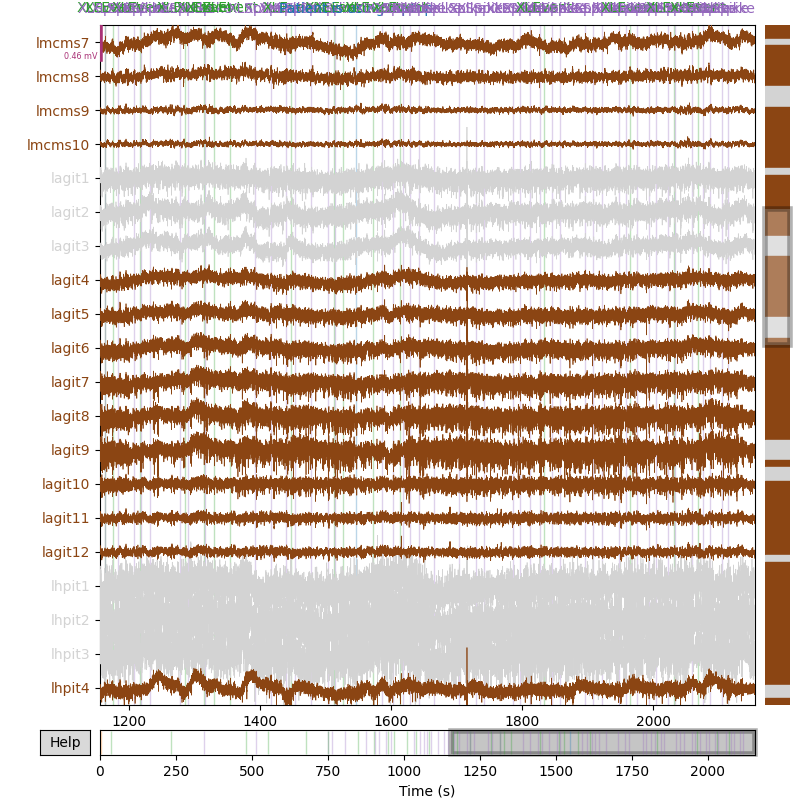

<IPython.core.display.Javascript object>


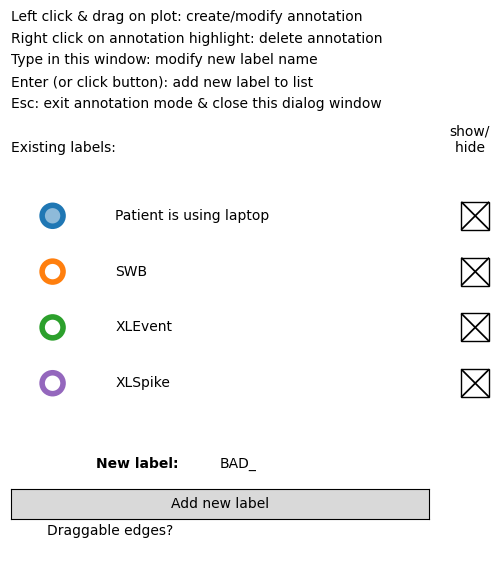

In [137]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=20, scalings=mne_data._data.max()/50)
fig.fake_keypress('a')

In [138]:
mne_data.info['bads']

['lptpt9',
 'lhpit1',
 'lhpit2',
 'lhpit3',
 'lacas1',
 'lacas2',
 'lacas3',
 'lagit1',
 'lagit2',
 'laias1',
 'laias2',
 'lpcpp7',
 'lpipm2',
 'lptpt8',
 'lptpt7',
 'lmolf3',
 'lmcms1',
 'lpcpp8',
 'lagit3']

In [139]:
mne_data.info #sanity check that bads info saved

<Info | 12 non-empty values
 bads: 19 items (lptpt9, lhpit1, lhpit2, lhpit3, lacas1, lacas2, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 100 sEEG
 custom_ref_applied: False
 dig: 100 items (100 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 21:08:00 UTC
 meas_id: 4 items (dict)
 nchan: 100
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [140]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [141]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=17, n_times=1077656
    Range : 0 ... 1077655 =      0.000 ...  2155.310 secs
Ready.
Added the following bipolar channels:
lacas5-lacas6, lacas6-lacas7, lagit9-lagit10, laias3-laias4, laias9-laias10, laias10-laias11, lhpit8-lhpit9, lhpit9-lhpit10, lmcms2-lmcms3, lmcms3-lmcms4, lmolf1-lmolf2, lpipm1-lpipm3, lpipm3-lpipm4, lpipm4-lpipm5, lpipm8-lpipm9, lpipm9-lpipm10, lpipm10-lpipm11


In [142]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 17 x 1077656 (2155.3 s), ~139.8 MB, data loaded>

In [143]:
mne_data_bp_reref.ch_names

['lacas5-lacas6',
 'lacas6-lacas7',
 'lagit9-lagit10',
 'laias3-laias4',
 'laias9-laias10',
 'laias10-laias11',
 'lhpit8-lhpit9',
 'lhpit9-lhpit10',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmolf1-lmolf2',
 'lpipm1-lpipm3',
 'lpipm3-lpipm4',
 'lpipm4-lpipm5',
 'lpipm8-lpipm9',
 'lpipm9-lpipm10',
 'lpipm10-lpipm11']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


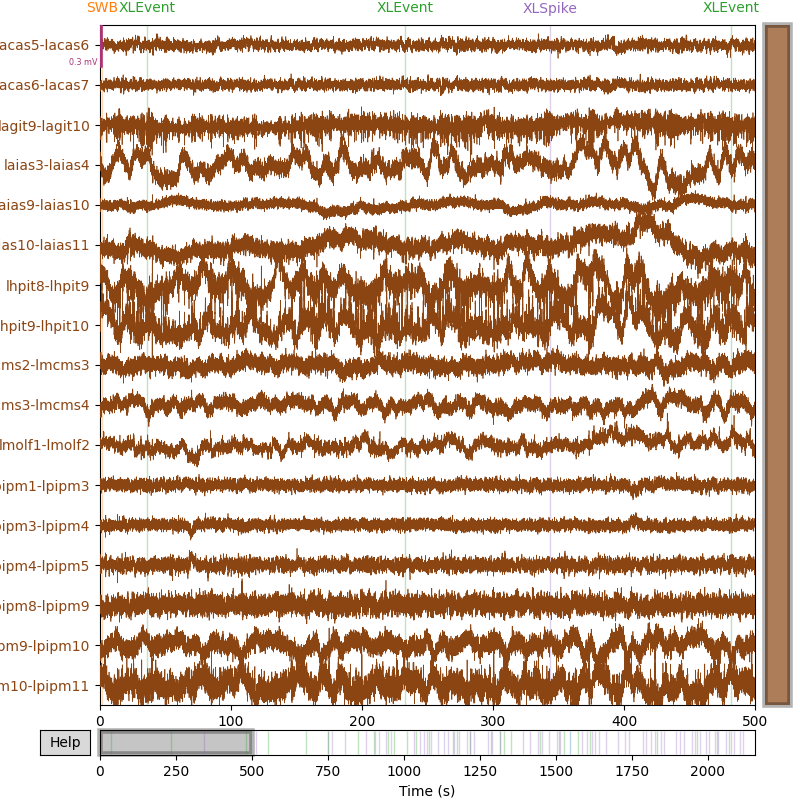

<IPython.core.display.Javascript object>


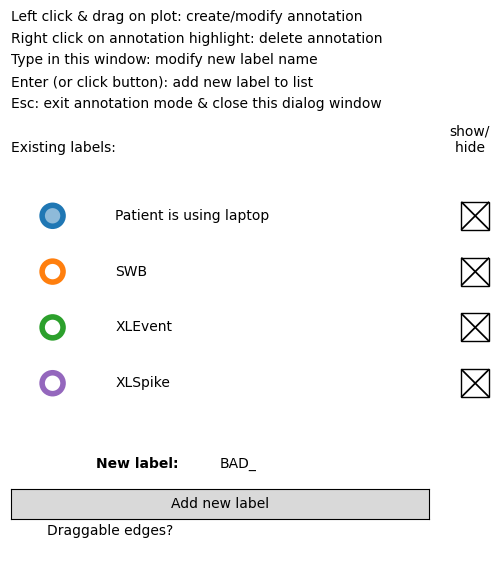

In [144]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=20, scalings=mne_data_bp_reref._data.max()/5)
fig.fake_keypress('a')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


<IPython.core.display.Javascript object>


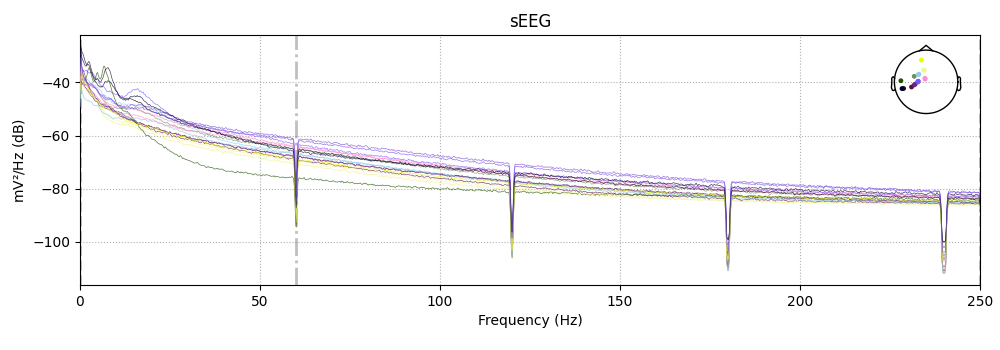

<IPython.core.display.Javascript object>


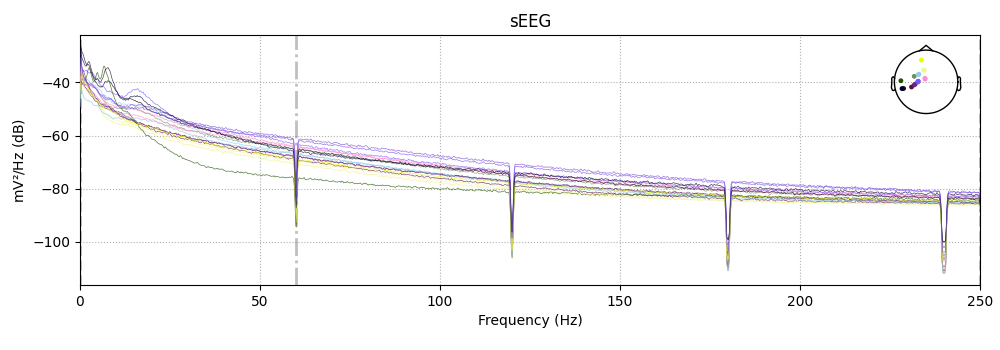

In [145]:
mne_data_bp_reref.plot_psd()

In [146]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/bp_ref_ieeg.fif
[done]


## Save mne_data

In [147]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [148]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [149]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/photodiode.fif...
Isotrak not found
    Range : 0 ... 1077655 =      0.000 ...  2155.310 secs
Ready.
Reading 0 ... 1077655  =      0.000 ...  2155.310 secs...


In [150]:
photodiode_data

<Raw | photodiode.fif, 1 x 1077656 (2155.3 s), ~8.2 MB, data loaded>

In [181]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.7

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 120 of 159 pulses


In [182]:
print(slope, offset,smoothSize,windSize,height)

0.9999920327912674 -25.482029537923495 11 15 0.7


In [153]:
[(x*slope + offset) for x in beh_ts]

[462.5051899350616,
 473.21676139305794,
 485.00196149715816,
 503.38434473970733,
 515.1407500732287,
 525.9217862777759,
 543.5461559596274,
 555.2598459334687,
 563.8824769346215,
 576.5957449445543,
 586.2558435799207,
 596.0882190427068,
 611.4437058013631,
 621.3032439477383,
 633.6024848563384,
 651.4397413420611,
 660.4103362708898,
 669.8059407135514,
 682.6224449009728,
 694.202400840313,
 705.1209832489966,
 719.0038273405974,
 731.7150162670958,
 742.3707040703305,
 758.6493733737407,
 768.4256513834703,
 779.5788571228449,
 795.5111668857968,
 804.7340511045676,
 813.6202610057148,
 831.3919171140923,
 842.7054063764446,
 851.5334447410595,
 864.5743782403908,
 874.6810928174451,
 883.7082224958474,
 898.4236100543477,
 907.4830363754347,
 916.1997061273512,
 931.022539929801,
 941.9135005585534,
 951.7424400487158,
 967.3689878477567,
 979.8899984894573,
 990.1934816987991,
 1007.1162263706873,
 1018.5334806063146,
 1028.2049699509266,
 1043.5615457009076,
 1052.917313460

In [136]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [154]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [155]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [156]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [157]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/bp_ref_ieeg.fif...
    Range : 0 ... 1077655 =      0.000 ...  2155.310 secs
Ready.
Reading 0 ... 1077655  =      0.000 ...  2155.310 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.2s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 17 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/bp_ref_ieeg.fif...
    Range : 0 ... 1077655 =      0.000 ...  2155.310 secs
Ready.
Reading 0 ... 1077655  =      0.000 ...  2155.310 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.8s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 17 columns


In [158]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~29.3 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~68.2 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [159]:
behav_df.columns

Index(['Round', 'Trial Num', 'TrialType', 'TrialOnset', 'ChoiceOnset',
       'DecisionOnset', 'FeedbackOnset', 'RT', 'SafeBet', 'LowBet', 'HighBet',
       'HighBetPos', 'GamblePos', 'ChoicePos', 'GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegr

In [160]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegret_emmap', 'util_dRegret_emmap',
       'util_tRelief_emmap', 'util_dRelief_emmap', 'util_RPE_emmap',
       'util_pRPE_emmap', 'util_nRPE_emmap']

In [161]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 75 columns
Replacing existing metadata with 75 columns


In [162]:
epochs_all_evs[event].metadata

lacas5-lacas6 lacas6-lacas7 lagit9-lagit10 laias3-laias4 laias9-laias10  \
0             NaN           NaN            NaN           NaN            NaN   
1           noise           NaN            NaN           NaN            NaN   
2             NaN           NaN            NaN           NaN            NaN   
3             NaN           NaN            NaN           NaN            NaN   
4             NaN           NaN            NaN           NaN          noise   
..            ...           ...            ...           ...            ...   
145           NaN           NaN            NaN         noise            NaN   
146           NaN           NaN            NaN           NaN            NaN   
147           NaN         noise            NaN           NaN          noise   
148           NaN           NaN            NaN           NaN            NaN   
149           NaN           NaN            NaN           NaN            NaN   

    laias10-laias11 lhpit8-lhpit9 lhpit9-lhpit10 lmcms2-lmcms3 lmcms3-lmcms4  \
0               NaN           NaN            NaN         noise           NaN   
1               NaN           NaN            NaN           NaN           NaN   
2               NaN         noise            NaN           NaN           NaN   
3               NaN           NaN            NaN           NaN           NaN   
4               NaN           NaN            NaN           NaN           NaN   
..              ...           ...            ...           ...           ...   
145             NaN           NaN            NaN           NaN           NaN   
146             NaN           NaN            NaN         noise           NaN   
147             NaN           NaN            NaN           NaN           NaN   
148             NaN           NaN            NaN           NaN           NaN   
149             NaN           NaN            NaN           NaN           NaN   

     ... util_dCPE_emmap util_tCF_emmap util_dCF_emmap util_tRegret_emmap  \
0    ...        0.297178      -0.831584      -0.831584           0.000000   
1    ...       -0.341744       0.113210       0.000000          -0.454954   
2    ...        0.042582       0.321506       0.321506           0.042582   
3    ...        0.015694       0.000000      -0.534407          -0.518712   
4    ...       -0.667446       1.133102       1.133102          -0.667446   
..   ...             ...            ...            ...                ...   
145  ...        0.521864       0.000000       0.364088           0.000000   
146  ...       -0.839548       0.839548       0.839548          -0.839548   
147  ...       -0.569345       1.014708       0.569345          -1.014708   
148  ...        0.573821      -0.573821      -0.573821           0.000000   
149  ...        0.573821      -0.573821      -0.573821           0.000000   

    util_dRegret_emmap util_tRelief_emmap util_dRelief_emmap util_RPE_emmap  \
0             0.000000           0.297178           0.297178       0.000000   
1            -0.341744           0.000000           0.000000      -0.113210   
2             0.042582           0.000000           0.000000       0.000000   
3             0.015694           0.000000           0.000000       0.000000   
4            -0.667446           0.000000           0.000000       0.000000   
..                 ...                ...                ...            ...   
145           0.000000           0.885952           0.521864       0.000000   
146          -0.839548           0.000000           0.000000       0.000000   
147          -0.569345           0.000000           0.000000      -1.014708   
148           0.000000           0.573821           0.573821       0.000000   
149           0.000000           0.573821           0.573821       0.000000   

     util_pRPE_emmap  util_nRPE_emmap  
0                0.0         0.000000  
1                0.0        -0.113210  
2                0.0         0.000000  
3                0.0         0.000000  
4                0.0

### Save raw epoched data 

In [163]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [164]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [165]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [166]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [167]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


Not setting metadata


In [168]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 17, ~292.5 MB>}

In [169]:
power_epochs = {}

In [170]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=False, ## make sure this is FALSE!
                                                  baseline_only=True)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



Not setting metadata
Not setting metadata
Adding metadata with 75 columns


In [171]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 17, ~1.43 GB>

In [172]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [173]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)


01252024


In [174]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

-25.482029537923495


<IPython.core.display.Javascript object>


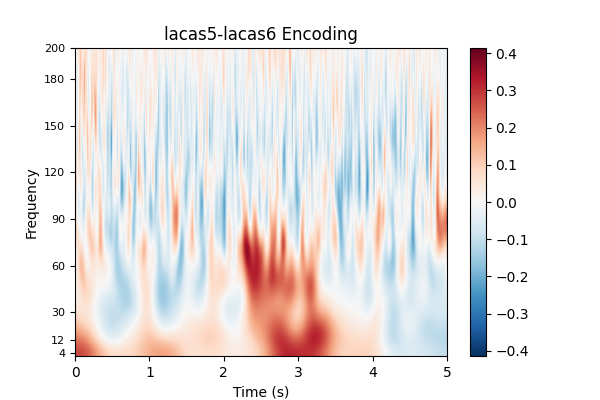

<IPython.core.display.Javascript object>


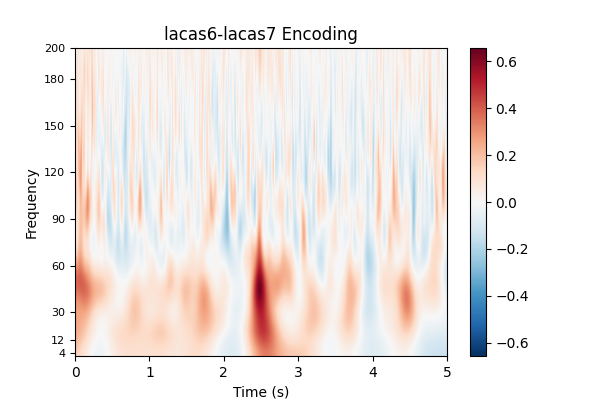

<IPython.core.display.Javascript object>


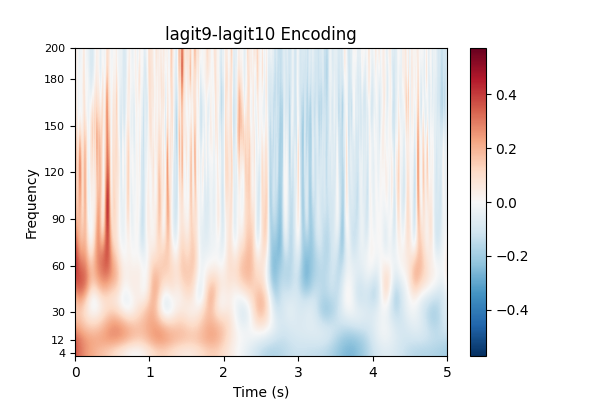

<IPython.core.display.Javascript object>


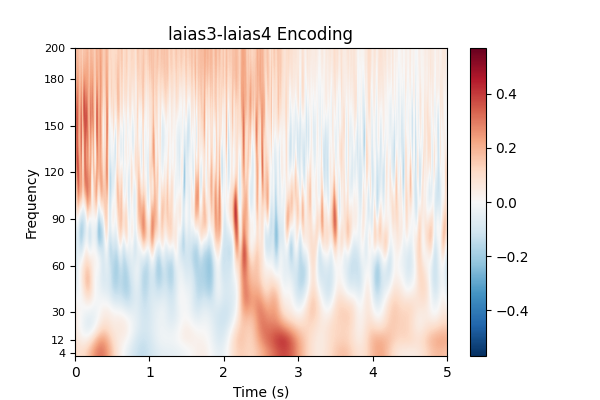

<IPython.core.display.Javascript object>


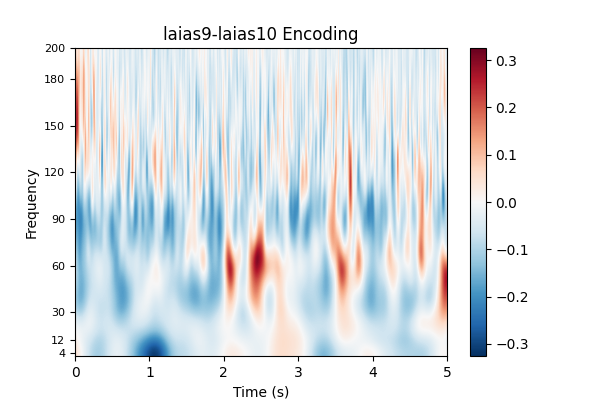

<IPython.core.display.Javascript object>


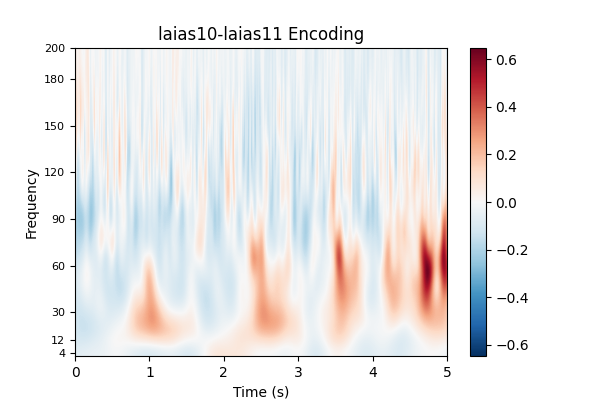

<IPython.core.display.Javascript object>


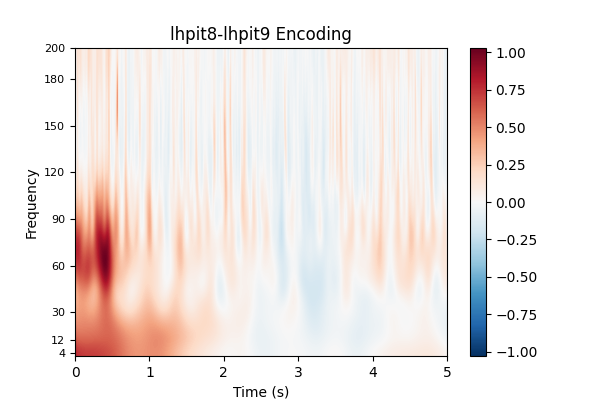

<IPython.core.display.Javascript object>


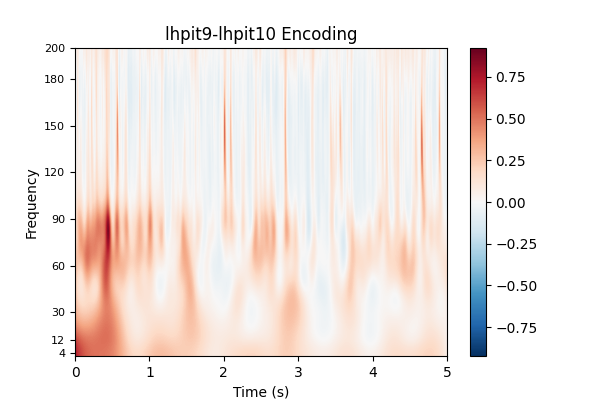

<IPython.core.display.Javascript object>


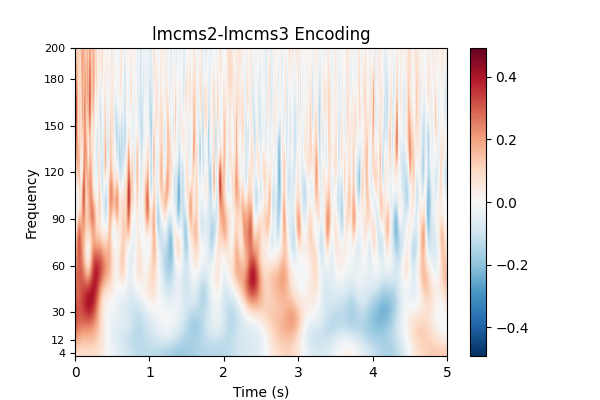

<IPython.core.display.Javascript object>


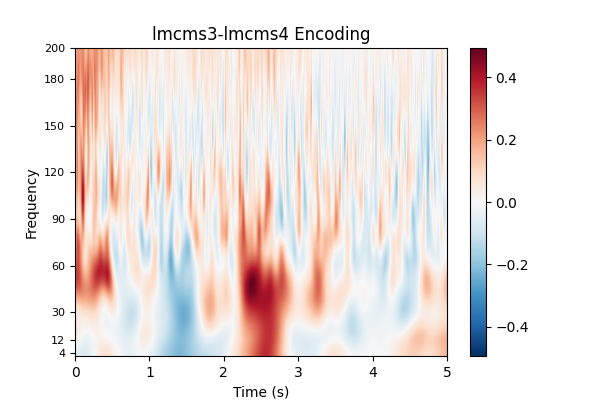

<IPython.core.display.Javascript object>


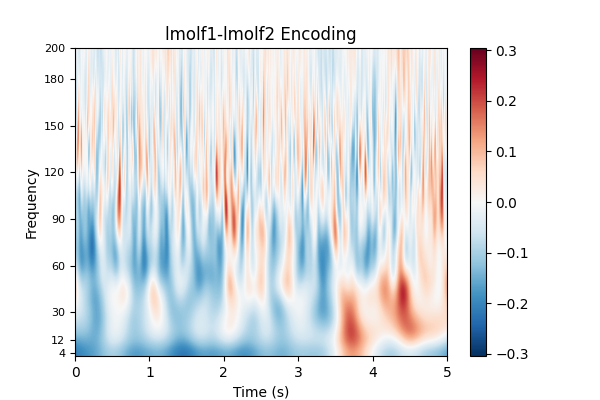

<IPython.core.display.Javascript object>


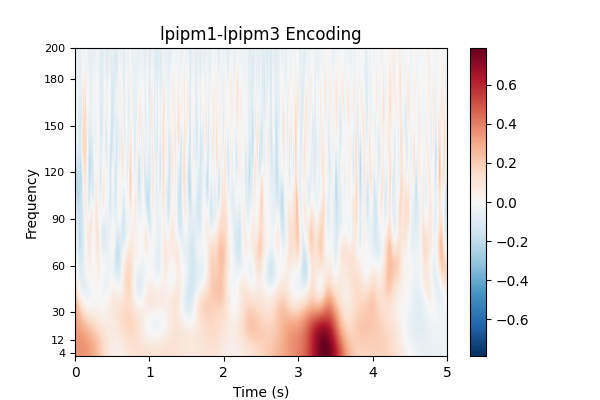

<IPython.core.display.Javascript object>


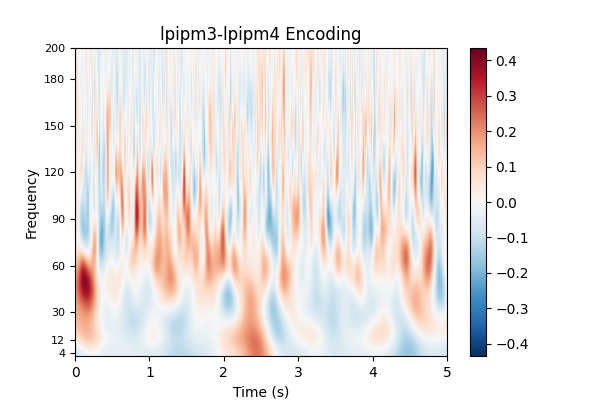

<IPython.core.display.Javascript object>


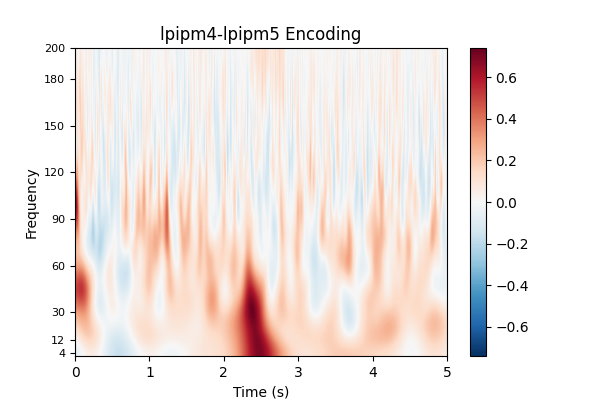

<IPython.core.display.Javascript object>


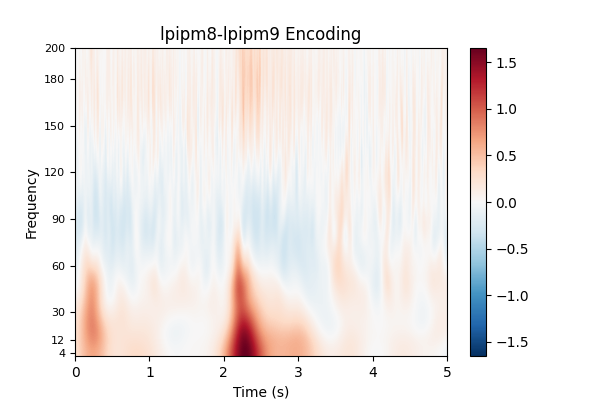

<IPython.core.display.Javascript object>


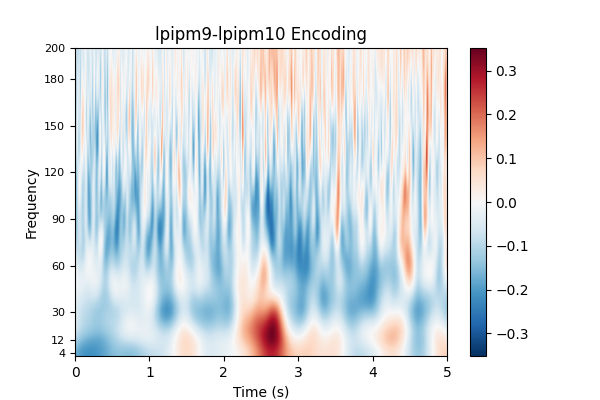

<IPython.core.display.Javascript object>


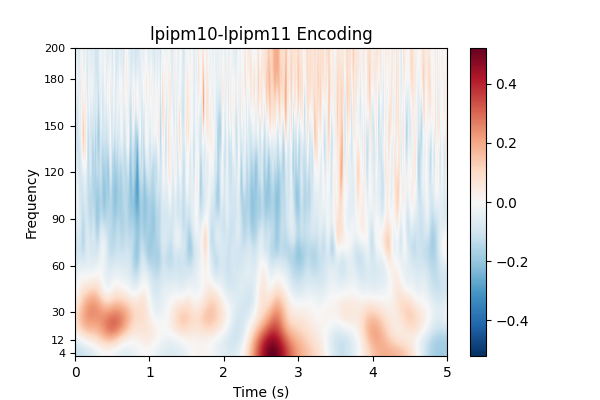

In [175]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
#     plt.close()
